In [1]:
# MovieLense
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from pycleora import SparseMatrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


2025-01-09 15:48:44.048787: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 15:48:44.049810: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 15:48:44.054306: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 15:48:44.066799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736434124.089027  738899 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736434124.09

## Hyperparameters - both for cleora and additional models

In [2]:
config = {
    # embedding computation
    "cleora_n_iter": 2,
    "cleora_dim": 512,
    # dataset preparation
    "train_test_split": 0.2,
    "batch_size": 256,
    "test_batch_size": 1000,
    "epochs": [10],
    "alpha": [1e-4],
}

## Downloading the data

In [3]:
data_dir = "../data"

In [4]:
def get_data(ds_name="movielens/100k-ratings"):
    def genre_id_to_text(genre_ids):
        return [genres[id] for id in genre_ids]

    ds = tfds.load(
        name=ds_name,
        split="all",
        data_dir=data_dir,
    )
    df = tfds.as_dataframe(ds)

    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].apply(
                lambda x: x.decode("utf-8") if isinstance(x, bytes) else x
            )

    genres = [
        "Action",
        "Adventure",
        "Animation",
        "Children",
        "Comedy",
        "Crime",
        "Documentary",
        "Drama",
        "Fantasy",
        "Film-Noir",
        "Horror",
        "IMAX",
        "Musical",
        "Mystery",
        "Romance",
        "Sci-Fi",
        "Thriller",
        "War",
        "Western",
        "unknown",
    ]
    df["genres_id"] = df["movie_genres"]
    df["movie_genres"] = df["movie_genres"].apply(genre_id_to_text)

    return df


In [5]:
data = get_data("movielens/1m-ratings")
data.head()


2025-01-09 15:48:46.241653: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-01-09 15:48:46.382255: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-09 15:51:08.291631: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


bucketized_user_age      movie_genres movie_id  \
0                 35.0   [Action, Drama]     3107   
1                 25.0           [Drama]     2114   
2                 18.0  [Comedy, Sci-Fi]      256   
3                 18.0  [Action, Horror]     1389   
4                 18.0          [Action]     3635   

                    movie_title   timestamp  user_gender user_id  \
0              Backdraft (1991)   977432193         True     130   
1         Outsiders, The (1983)   965932967        False    3829   
2                 Junior (1994)  1012103552        False    1265   
3               Jaws 3-D (1983)   972004605         True    2896   
4  Spy Who Loved Me, The (1977)   961180111         True    5264   

   user_occupation_label  user_occupation_text  user_rating user_zip_code  \
0                     18   technician/engineer          5.0         50021   
1                      0     academic/educator          4.0         22307   
2                     21                writer          1.0         49321   
3                     14       sales/marketing          5.0         60073   
4                     17  college/grad student          4.0         15217   

  genres_id  
0    [0, 7]  
1       [7]  
2   [4, 15]  
3   [0, 10]  
4       [0]

In [6]:
additional_rows = []

Getting top 10 movies from each age group -> "Common movies people your age enjoyed"

In [7]:
global_mean = data['user_rating'].mean()
min_ratings = 5  

movie_stats = data.groupby(['bucketized_user_age', 'movie_id']).agg(
    num_ratings=('user_rating', 'count'),
    avg_rating=('user_rating', 'mean')
).reset_index()

movie_stats['bayesian_avg'] = (
    (movie_stats['avg_rating'] * movie_stats['num_ratings'] + global_mean * min_ratings) /
    (movie_stats['num_ratings'] + min_ratings)
)

result = movie_stats.sort_values(['bucketized_user_age', 'bayesian_avg'], ascending=[True, False])


In [8]:
top_10_movies_grouped_age = result.groupby('bucketized_user_age').head(10)

In [9]:
for i in top_10_movies_grouped_age.groupby("bucketized_user_age"):
    print(i[0])
    print(i[1]['movie_id'].tolist())
    additional_rows.append(i[1]['movie_id'].tolist())

1.0
['1213', '923', '318', '3000', '1212', '903', '916', '2571', '2010', '1228']
18.0
['50', '318', '2019', '745', '2324', '2858', '1148', '2905', '858', '527']
25.0
['318', '1198', '260', '858', '50', '745', '2019', '904', '1148', '1178']
35.0
['922', '1207', '858', '2019', '527', '3307', '318', '1198', '904', '750']
45.0
['527', '1148', '912', '2019', '318', '745', '1207', '904', '3089', '2762']
50.0
['2019', '3030', '1148', '913', '912', '527', '858', '1207', '750', '969']
56.0
['527', '1207', '912', '969', '919', '913', '899', '1148', '1250', '3095']


In [10]:
additional_rows

[['1213', '923', '318', '3000', '1212', '903', '916', '2571', '2010', '1228'],
 ['50', '318', '2019', '745', '2324', '2858', '1148', '2905', '858', '527'],
 ['318', '1198', '260', '858', '50', '745', '2019', '904', '1148', '1178'],
 ['922', '1207', '858', '2019', '527', '3307', '318', '1198', '904', '750'],
 ['527', '1148', '912', '2019', '318', '745', '1207', '904', '3089', '2762'],
 ['2019', '3030', '1148', '913', '912', '527', '858', '1207', '750', '969'],
 ['527', '1207', '912', '969', '919', '913', '899', '1148', '1250', '3095']]

## Prepare the data for proper embeddings

In [11]:
df = pd.DataFrame(data, columns=["movie_id", "user_id", "user_rating"])
negative_ratings = df[df["user_rating"] < 4].index

# Drop columns where rating < 4 -> we don't want to create a connection if user doesn't like the movie
df.drop(negative_ratings, inplace=True)



### Train-Test split - used for evaluation of our methods - maybe not needed??

In [12]:
# train, test = train_test_split(df, test_size=config["train_test_split"])
# train.shape, test.shape


In [13]:
# We do this after test-train spit to avoid data leakege

# Multiply the occurences if the score is 5 -> create a stronger connection  
df  = df.loc[df.index.repeat((df.user_rating-3)**2)]

In [14]:
df[df['movie_id']=='425']

movie_id user_id  user_rating
16881       425    2863          4.0
19348       425    5589          4.0
27350       425    5526          4.0
32760       425    4169          4.0
46680       425     687          4.0
...         ...     ...          ...
952024      425    1043          5.0
952024      425    1043          5.0
952024      425    1043          5.0
952024      425    1043          5.0
962279      425    3049          4.0

[104 rows x 3 columns]

In [15]:

# Drop columns we won't be using
df.drop(columns=["user_rating"], inplace=True)


In [16]:
df.head()

movie_id user_id
0     3107     130
0     3107     130
0     3107     130
0     3107     130
1     2114    3829

In [17]:
clique = df.groupby('user_id')['movie_id'].apply(list).values


In [18]:
rows_arr =  np.zeros(len(additional_rows), dtype=object)
for i in range(len(additional_rows)):
    rows_arr[i] = additional_rows[i]
rows_arr

array([list(['1213', '923', '318', '3000', '1212', '903', '916', '2571', '2010', '1228']),
       list(['50', '318', '2019', '745', '2324', '2858', '1148', '2905', '858', '527']),
       list(['318', '1198', '260', '858', '50', '745', '2019', '904', '1148', '1178']),
       list(['922', '1207', '858', '2019', '527', '3307', '318', '1198', '904', '750']),
       list(['527', '1148', '912', '2019', '318', '745', '1207', '904', '3089', '2762']),
       list(['2019', '3030', '1148', '913', '912', '527', '858', '1207', '750', '969']),
       list(['527', '1207', '912', '969', '919', '913', '899', '1148', '1250', '3095'])],
      dtype=object)

In [19]:
temp = list(clique) 
temp.extend(list(rows_arr))
clique =  np.asanyarray(temp, dtype=object)

In [20]:
cleora_input = map(lambda x: ' '.join(x), clique)


In [21]:

# Create Markov transition matrix for the hypergraph

# Only one column - complex::reflexive
mat = SparseMatrix.from_iterator(cleora_input, columns='complex::reflexive::movie')


# Look at entity ids in the matrix, corresponding to embedding vectors
print(mat.entity_ids)

# Initialize embedding vectors externally, using text, image, random vectors
# embeddings = ...

# Or use built-in random deterministic initialization
embeddings = mat.initialize_deterministically(config["cleora_dim"])



['1097', '1270', '2018', '260', '150', '2028', '1545', '1836', '1962', '919', '1961', '2804', '2918', '1287', '2692', '3114', '1193', '783', '2791', '1207', '588', '1', '2797', '1246', '1566', '2762', '531', '2398', '3186', '594', '938', '1028', '527', '2355', '1035', '48', '3408', '1029', '608', '3105', '595', '1022', '2294', '1721', '1907', '32', '590', '1959', '3189', '1080', '648', '1409', '3039', '248', '7', '3347', '1573', '2140', '3072', '1204', '1380', '317', '292', '2657', '2967', '3481', '2874', '3296', '3928', '3593', '1257', '3447', '3591', '2135', '318', '2617', '3034', '2043', '3699', '2009', '1079', '2424', '2321', '2968', '1031', '3812', '1948', '435', '1286', '1019', '2375', '2108', '1084', '780', '802', '971', '3500', '1210', '2640', '2529', '1271', '2011', '1947', '1042', '2049', '2399', '1129', '1293', '914', '1408', '1009', '2109', '3671', '1127', '750', '2407', '2115', '1196', '3095', '2431', '2136', '1371', '2003', '2405', '1339', '3259', '2000', '1135', '3675', 

In [22]:
# Perform Markov random walk, then normalize however many times we want

# The optimal number depends on the graph, typically between 3 and 7 yields good results
# lower values tend to capture co-occurrence, higher iterations capture substitutability in a context

for i in range(config['cleora_n_iter']):
    # Can propagate with a symmetric matrix as well, but left Markov is a great default
    embeddings = mat.left_markov_propagate(embeddings)
    # Normalize with L2 norm by default, for the embeddings to reside on a hypersphere. Can use standardization instead.
    embeddings /= np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)

# We're done, here are our embeddings





In [23]:
id_to_title = data.groupby("movie_id")['movie_title'].first().to_dict()


In [24]:
len(id_to_title)

3706

In [25]:
# for entity, embedding in zip(mat.entity_ids, embeddings):
#     print(id_to_title[entity], embedding)
#     break

In [26]:
embeddings_df = pd.DataFrame(
    embeddings,
    mat.entity_ids
    # , index=np.asanyarray(map(lambda x: x, mat.entity_ids))
)

In [28]:
data.columns

Index(['bucketized_user_age', 'movie_genres', 'movie_id', 'movie_title',
       'timestamp', 'user_gender', 'user_id', 'user_occupation_label',
       'user_occupation_text', 'user_rating', 'user_zip_code', 'genres_id'],
      dtype='object')

In [29]:
movie_metadata = data.drop(columns=['bucketized_user_age', 
       'timestamp', 'user_gender', 'user_id',
       'user_occupation_label', 'user_occupation_text', 'user_rating',
       'user_zip_code'])
# data.groupby("movie_id")

In [30]:
movie_metadata

movie_genres movie_id  \
0                    [Action, Drama]     3107   
1                            [Drama]     2114   
2                   [Comedy, Sci-Fi]      256   
3                   [Action, Horror]     1389   
4                           [Action]     3635   
...                              ...      ...   
1000204              [Comedy, Drama]     2290   
1000205  [Action, Adventure, Sci-Fi]     2643   
1000206            [Drama, Thriller]      593   
1000207                      [Drama]     1693   
1000208            [Drama, Thriller]      454   

                                     movie_title   genres_id  
0                               Backdraft (1991)      [0, 7]  
1                          Outsiders, The (1983)         [7]  
2                                  Junior (1994)     [4, 15]  
3                                Jaws 3-D (1983)     [0, 10]  
4                   Spy Who Loved Me, The (1977)         [0]  
...                                          ...         ...  
1000204                 Stardust Memories (1980)      [4, 7]  
1000205  Superman IV: The Quest for Peace (1987)  [0, 1, 15]  
1000206         Silence of the Lambs, The (1991)     [7, 16]  
1000207                           Amistad (1997)         [7]  
1000208                         Firm, The (1993)     [7, 16]  

[1000209 rows x 4 columns]

In [31]:
embeddings_df['movie_id'] = embeddings_df.index

In [32]:
# embeddings_df.join

In [33]:
embeddings_combined = pd.merge(embeddings_df, movie_metadata, on='movie_id', how='left')

In [34]:
embeddings_combined

0         1         2         3         4         5         6  \
0      -0.039724 -0.110281 -0.019514  0.105661 -0.031181  0.057734  0.081095   
1      -0.039724 -0.110281 -0.019514  0.105661 -0.031181  0.057734  0.081095   
2      -0.039724 -0.110281 -0.019514  0.105661 -0.031181  0.057734  0.081095   
3      -0.039724 -0.110281 -0.019514  0.105661 -0.031181  0.057734  0.081095   
4      -0.039724 -0.110281 -0.019514  0.105661 -0.031181  0.057734  0.081095   
...          ...       ...       ...       ...       ...       ...       ...   
999631 -0.033451 -0.112093 -0.042274  0.111568 -0.028097  0.066100  0.070557   
999632 -0.033451 -0.112093 -0.042274  0.111568 -0.028097  0.066100  0.070557   
999633 -0.034376 -0.109451  0.013815  0.128257 -0.020320  0.033467  0.082974   
999634 -0.034376 -0.109451  0.013815  0.128257 -0.020320  0.033467  0.082974   
999635 -0.034376 -0.109451  0.013815  0.128257 -0.020320  0.033467  0.082974   

               7         8         9  ...       506       507       508  \
0      -0.033026  0.030943 -0.009971  ... -0.024668  0.063052 -0.026236   
1      -0.033026  0.030943 -0.009971  ... -0.024668  0.063052 -0.026236   
2      -0.033026  0.030943 -0.009971  ... -0.024668  0.063052 -0.026236   
3      -0.033026  0.030943 -0.009971  ... -0.024668  0.063052 -0.026236   
4      -0.033026  0.030943 -0.009971  ... -0.024668  0.063052 -0.026236   
...          ...       ...       ...  ...       ...       ...       ...   
999631 -0.029476  0.030820 -0.019652  ...  0.002030  0.051829 -0.025015   
999632 -0.029476  0.030820 -0.019652  ...  0.002030  0.051829 -0.025015   
999633 -0.048603  0.054325 -0.015416  ... -0.069381  0.050833 -0.030658   
999634 -0.048603  0.054325 -0.015416  ... -0.069381  0.050833 -0.030658   
999635 -0.048603  0.054325 -0.015416  ... -0.069381  0.050833 -0.030658   

             509       510       511  movie_id  \
0      -0.073227  0.007395  0.026011      1097   
1      -0.073227  0.007395  0.026011      1097   
2      -0.073227  0.007395  0.026011      1097   
3      -0.073227  0.007395  0.026011      1097   
4      -0.073227  0.007395  0.026011      1097   
...          ...       ...       ...       ...   
999631 -0.077525 -0.014640  0.026486      1102   
999632 -0.077525 -0.014640  0.026486      1102   
999633 -0.075816 -0.022739 -0.002200      3482   
999634 -0.075816 -0.022739 -0.002200      3482   
999635 -0.075816 -0.022739 -0.002200      3482   

                              movie_genres                        movie_title  \
0       [Children, Drama, Fantasy, Sci-Fi]  E.T. the Extra-Terrestrial (1982)   
1       [Children, Drama, Fantasy, Sci-Fi]  E.T. the Extra-Terrestrial (1982)   
2       [Children, Drama, Fantasy, Sci-Fi]  E.T. the Extra-Terrestrial (1982)   
3       [Children, Drama, Fantasy, Sci-Fi]  E.T. the Extra-Terrestrial (1982)   
4       [Children, Drama, Fantasy, Sci-Fi]  E.T. the Extra-Terrestrial (1982)   
...                                    ...                                ...   
999631                            [Action]             American Strays (1996)   
999632                            [Action]             American Strays (1996)   
999633                             [Drama]              Price of Glory (2000)   
999634                             [Drama]              Price of Glory (2000)   
999635                             [Drama]              Price of Glory (2000)   

            genres_id  
0       [3, 7, 8, 15]  
1       [3, 7, 8, 15]  
2       [3, 7, 8, 15]  
3       [3, 7, 8, 15]  
4       [3, 7, 8, 15]  
...               ...  
999631            [0]  
999632            [0]  
999633            [7]  
999634            [7]  
999635            [7]  

[999636 rows x 516 columns]

### Very advanced search engine

In [35]:
data[data['movie_title'].str.contains('kane', case=False, na=False)]['movie_title'].unique()

array(['Citizen Kane (1941)'], dtype=object)

In [36]:
example_movies = [
    # "Star Wars: Episode I - The Phantom Menace (1999)",
    # "Star Wars: Episode IV - A New Hope (1977)",
    # "Star Wars: Episode V - The Empire Strikes Back (1980)",
    # "Star Wars: Episode VI - Return of the Jedi (1983)",
    "Casablanca (1942)",
    "Citizen Kane (1941)",
    # "Bambi (1942)",
    "Lion King, The (1994)",
    "Wizard of Oz, The (1939)",
    "Godfather: Part II, The (1974)",
    # "Godfather: Part III, The (1990)",
    "Godfather, The (1972)",
    "Pulp Fiction (1994)",
    "Schindler's List (1993)",
    # "Three Colors: Blue (1993)",
    # "Three Colors: Red (1994)",
    # "Three Colors: White (1994)",
]


In [62]:
movie_ids = set(movie_metadata.loc[movie_metadata['movie_title'].isin(example_movies), 'movie_id'])

In [63]:
arrays = [embeddings_df.loc[[movie_id]].to_numpy()[0] for movie_id in movie_ids]


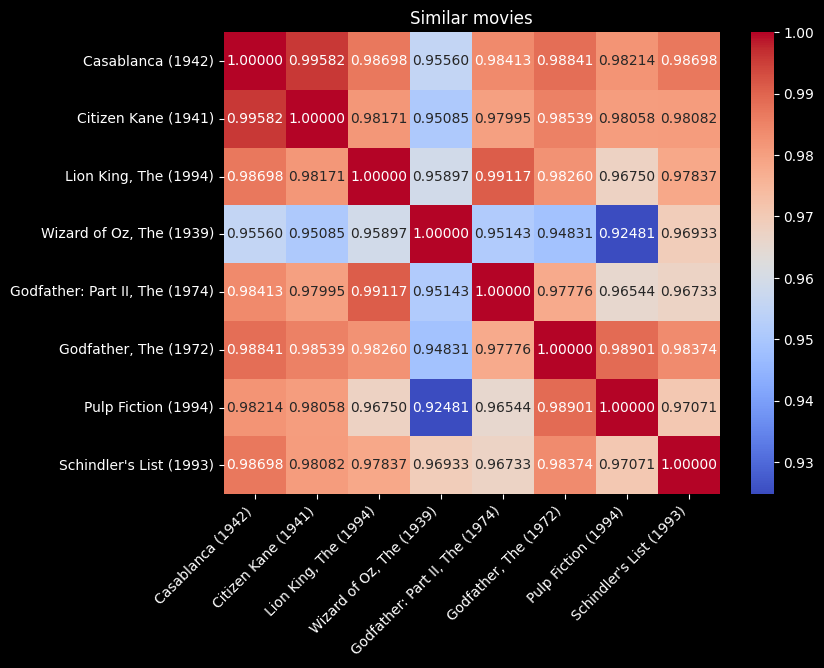

In [64]:
# We can now compare our embeddings with dot product (since they are L2 normalized)

n = len(arrays)
dot_products = np.zeros((n, n))  

for i in range(n):
    for j in range(n):
        dot_products[i, j] = np.dot(arrays[i], arrays[j])

plt.figure(figsize=(8, 6))
sns.heatmap(
    dot_products,
    annot=True,
    fmt=".5f",
    cmap="coolwarm",
    xticklabels=example_movies,
    yticklabels=example_movies,
)
plt.xticks(rotation=45, ha='right')
plt.title("Similar movies")
plt.show()

In [50]:
embeddings_df

0         1         2         3         4         5         6  \
1097 -0.039724 -0.110281 -0.019514  0.105661 -0.031181  0.057734  0.081095   
1270 -0.036540 -0.109721 -0.027014  0.114217 -0.037381  0.063703  0.089141   
2018 -0.036457 -0.111710 -0.017730  0.119992 -0.038840  0.060471  0.093847   
260  -0.026590 -0.109468 -0.035911  0.107683 -0.028791  0.057224  0.083578   
150  -0.039124 -0.109174 -0.009171  0.117083 -0.021495  0.051808  0.083731   
...        ...       ...       ...       ...       ...       ...       ...   
3800 -0.012113 -0.122529 -0.036156  0.126427  0.012887  0.003488  0.067316   
3346 -0.012113 -0.122529 -0.036156  0.126427  0.012887  0.003488  0.067316   
220  -0.031446 -0.080094 -0.028433  0.097128 -0.070307  0.078192  0.076522   
1102 -0.033451 -0.112093 -0.042274  0.111568 -0.028097  0.066100  0.070557   
3482 -0.034376 -0.109451  0.013815  0.128257 -0.020320  0.033467  0.082974   

             7         8         9  ...       503       504       505  \
1097 -0.033026  0.030943 -0.009971  ... -0.007370  0.078742 -0.037035   
1270 -0.028811  0.029494 -0.012344  ... -0.008521  0.079925 -0.045557   
2018 -0.026760  0.027653 -0.013617  ... -0.003688  0.078681 -0.038710   
260  -0.028638  0.024713 -0.010478  ... -0.005908  0.072557 -0.046226   
150  -0.039767  0.036220 -0.014210  ... -0.016523  0.077703 -0.031470   
...        ...       ...       ...  ...       ...       ...       ...   
3800 -0.031401  0.015166  0.003519  ...  0.011203  0.064474 -0.021764   
3346 -0.031401  0.015166  0.003519  ...  0.011203  0.064474 -0.021764   
220  -0.048304  0.014937  0.004910  ...  0.010768  0.037909 -0.048668   
1102 -0.029476  0.030820 -0.019652  ... -0.014228  0.084959 -0.024065   
3482 -0.048603  0.054325 -0.015416  ... -0.016971  0.084467 -0.027126   

           506       507       508       509       510       511  movie_id  
1097 -0.024668  0.063052 -0.026236 -0.073227  0.007395  0.026011      1097  
1270 -0.019005  0.061654 -0.022802 -0.079000  0.001787  0.024306      1270  
2018 -0.019250  0.049539 -0.012489 -0.078778  0.004982  0.030201      2018  
260  -0.015141  0.068027 -0.025711 -0.069990  0.006006  0.020435       260  
150  -0.033843  0.057485 -0.027539 -0.078912 -0.009138  0.014398       150  
...        ...       ...       ...       ...       ...       ...       ...  
3800 -0.052690  0.048452 -0.018752 -0.057250  0.016707  0.035616      3800  
3346 -0.052690  0.048452 -0.018752 -0.057250  0.016707  0.035616      3346  
220   0.004803  0.050829 -0.053685 -0.104922 -0.039626  0.017783       220  
1102  0.002030  0.051829 -0.025015 -0.077525 -0.014640  0.026486      1102  
3482 -0.069381  0.050833 -0.030658 -0.075816 -0.022739 -0.002200      3482  

[3533 rows x 513 columns]

In [51]:
ground_truth = dict(zip(movie_metadata['movie_id'], movie_metadata['movie_genres']))

In [52]:
ground_truth

{'3107': ['Action', 'Drama'],
 '2114': ['Drama'],
 '256': ['Comedy', 'Sci-Fi'],
 '1389': ['Action', 'Horror'],
 '3635': ['Action'],
 '2042': ['Children', 'Comedy'],
 '2289': ['Comedy', 'Drama'],
 '3334': ['Crime', 'Drama', 'Film-Noir', 'Thriller'],
 '2901': ['Horror', 'Sci-Fi'],
 '1206': ['Sci-Fi'],
 '3163': ['Drama'],
 '2348': ['Drama'],
 '112': ['Action', 'Adventure', 'Crime'],
 '2369': ['Comedy', 'Romance'],
 '1409': ['Comedy', 'Romance'],
 '288': ['Action', 'Thriller'],
 '586': ['Children', 'Comedy'],
 '1197': ['Action', 'Adventure', 'Comedy', 'Romance'],
 '2502': ['Comedy', 'Romance'],
 '2': ['Adventure', 'Children', 'Fantasy'],
 '1717': ['Horror', 'Thriller'],
 '2329': ['Drama'],
 '2527': ['Action', 'Sci-Fi', 'Thriller', 'unknown'],
 '344': ['Comedy'],
 '2455': ['Horror', 'Sci-Fi'],
 '2640': ['Action', 'Adventure', 'Sci-Fi'],
 '1179': ['Crime', 'Drama', 'Film-Noir'],
 '3481': ['Comedy'],
 '1073': ['Adventure', 'Children', 'Comedy', 'Fantasy'],
 '1193': ['Drama'],
 '1385': ['Actio

In [53]:
def transform_ground_truth(ground_truth):
    # Flatten the list of genres to get all unique genres
    unique_genres = set(genre for genres in ground_truth.values() for genre in genres)

    # Create a binary indicator matrix
    binary_matrix = pd.DataFrame(0, index=ground_truth.keys(), columns=list(unique_genres))

    # Fill in the matrix
    for movie, genres in ground_truth.items():
        binary_matrix.loc[movie, genres] = 1

    return binary_matrix


# Transform the ground truth
ground_truth_matrix = transform_ground_truth(ground_truth)

In [54]:
ground_truth_matrix

Documentary  Musical  Mystery  Drama  Adventure  Romance  Sci-Fi  \
3107            0        0        0      1          0        0       0   
2114            0        0        0      1          0        0       0   
256             0        0        0      0          0        0       1   
1389            0        0        0      0          0        0       0   
3635            0        0        0      0          0        0       0   
...           ...      ...      ...    ...        ...      ...     ...   
311             0        0        0      0          0        0       0   
2563            0        0        0      1          0        0       0   
763             0        0        0      1          0        0       0   
1724            0        0        0      1          0        0       0   
2584            0        0        0      0          0        0       0   

      Comedy  Film-Noir  Horror  Animation  Action  unknown  Children  \
3107       0          0       0          0       1        0         0   
2114       0          0       0          0       0        0         0   
256        1          0       0          0       0        0         0   
1389       0          0       1          0       1        0         0   
3635       0          0       0          0       1        0         0   
...      ...        ...     ...        ...     ...      ...       ...   
311        0          0       1          0       0        0         0   
2563       0          0       0          0       0        0         0   
763        0          0       0          0       0        0         0   
1724       0          0       0          0       0        0         0   
2584       1          0       0          0       0        0         0   

      Fantasy  Western  Thriller  Crime  
3107        0        0         0      0  
2114        0        0         0      0  
256         0        0         0      0  
1389        0        0         0      0  
3635        0        0         0      0  
...       ...      ...       ...    ...  
311         0        0         1      0  
2563        0        0         0      0  
763         0        0         0      0  
1724        0        0         0      0  
2584        0        0         0      0  

[3706 rows x 18 columns]

In [55]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


# Helper: Jaccard similarity between multi-label sets
def compute_jaccard_per_cluster(embeddings_df, cluster_labels, ground_truth_matrix):
    cluster_to_ids = defaultdict(list)
    for idx, cluster in zip(embeddings_df.index, cluster_labels):
        cluster_to_ids[cluster].append(idx)

    jaccard_scores = []
    for cluster, ids in cluster_to_ids.items():
        cluster_labels = ground_truth_matrix.loc[ids].sum(axis=0) > 0
        ground_truth_labels = ground_truth_matrix.sum(axis=0) > 0
        score = jaccard_score(ground_truth_labels, cluster_labels, average="macro")
        jaccard_scores.append(score)
    return sum(jaccard_scores) / len(jaccard_scores)


# Clustering
def perform_kmeans_clustering(embeddings_df, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_df)
    return cluster_labels, kmeans


# Visualization with t-SNE
def visualize_clusters(embeddings_df, cluster_labels):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings_df)

    # Plot the results
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=cluster_labels,
        palette=sns.color_palette("hsv", len(set(cluster_labels))),
        legend="full",
    )
    plt.title("t-SNE Visualization of Clusters")
    plt.show()
    
def visualize_genres(embeddings_df, cluster_labels):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings_df)

    # Plot the results
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=cluster_labels,
        palette=sns.color_palette("hsv", len(set(cluster_labels))),
        legend="full",
    )
    plt.title("t-SNE Visualization of Clusters")
    plt.show()
    

In [56]:
embeddings_df = embeddings_df.drop(columns=['movie_id'])

In [57]:
ground_truth_matrix.shape

(3706, 18)

Average Jaccard Similarity: 1.00
Silhouette Score: 0.08


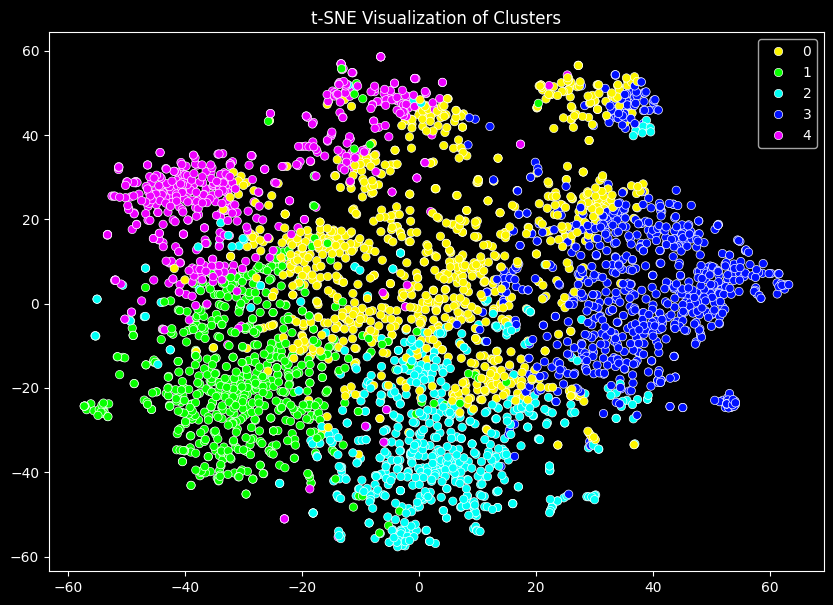

Average Jaccard Similarity: 0.91
Silhouette Score: 0.09


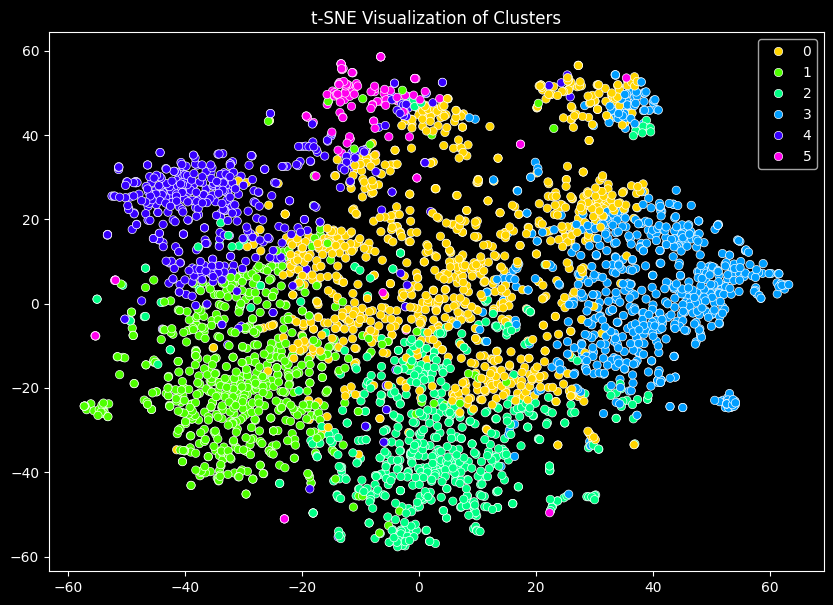

Average Jaccard Similarity: 0.68
Silhouette Score: 0.09


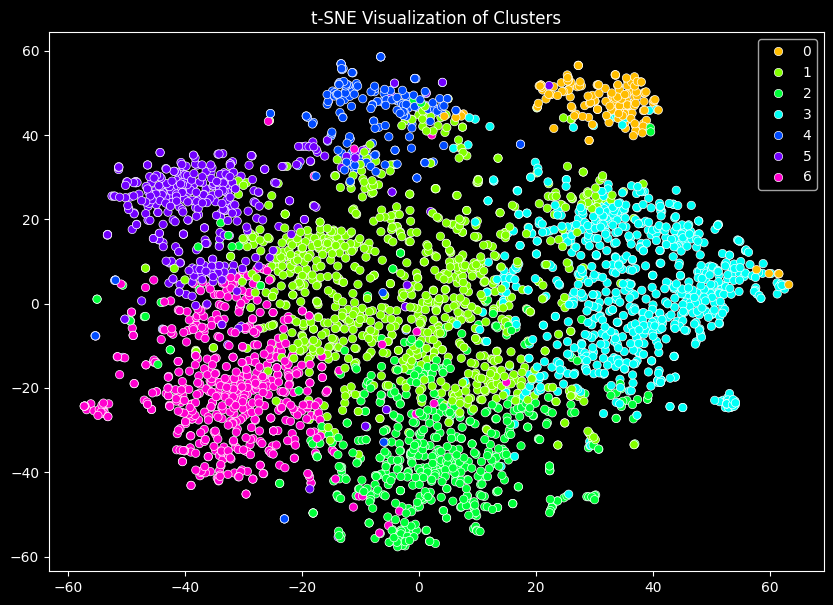

Average Jaccard Similarity: 0.78
Silhouette Score: 0.08


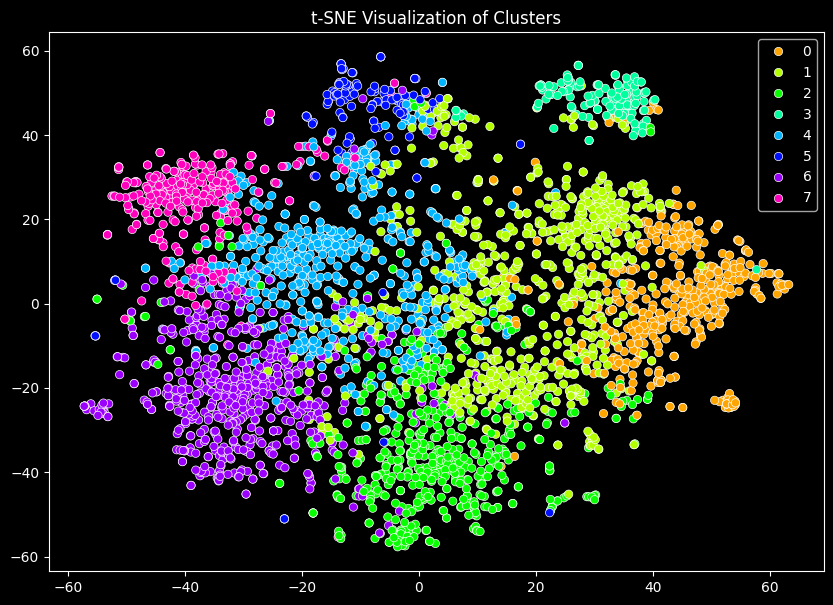

Average Jaccard Similarity: 0.68
Silhouette Score: 0.08


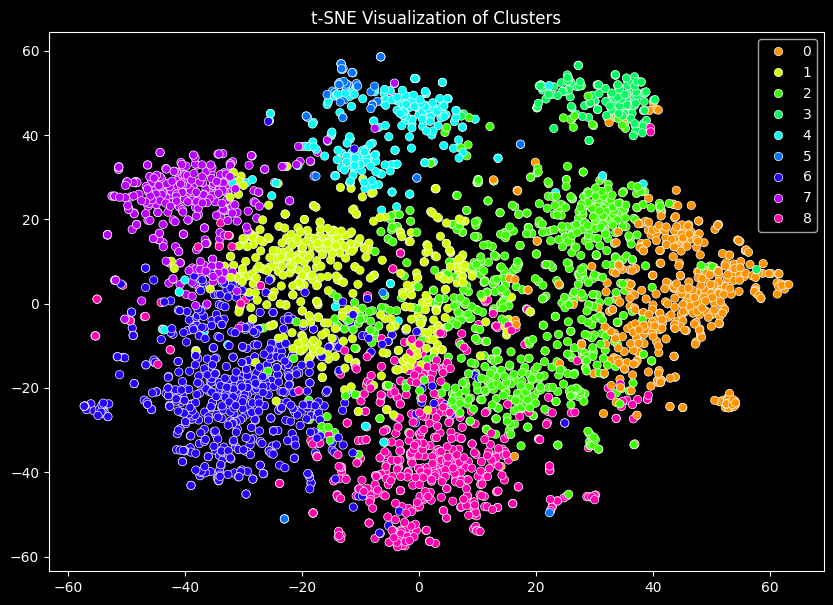

Average Jaccard Similarity: 0.64
Silhouette Score: 0.08


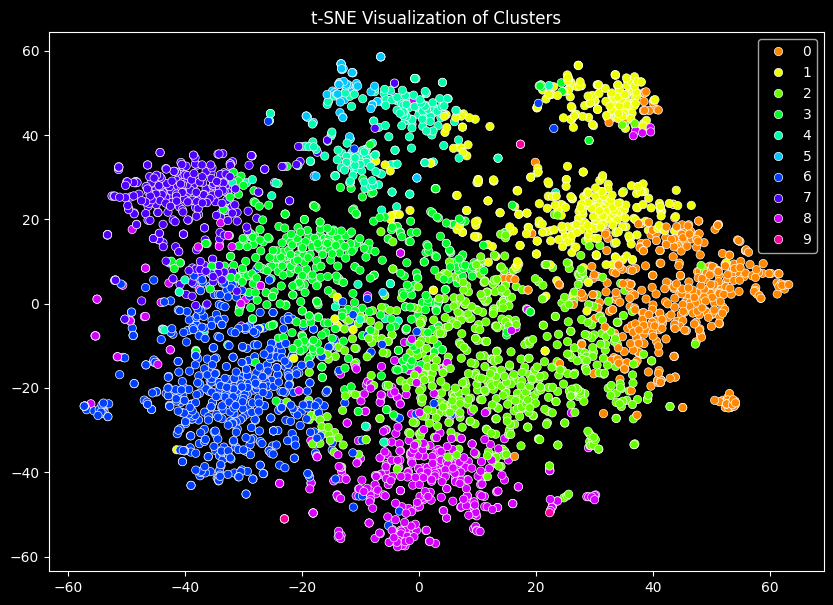

Average Jaccard Similarity: 0.61
Silhouette Score: 0.08


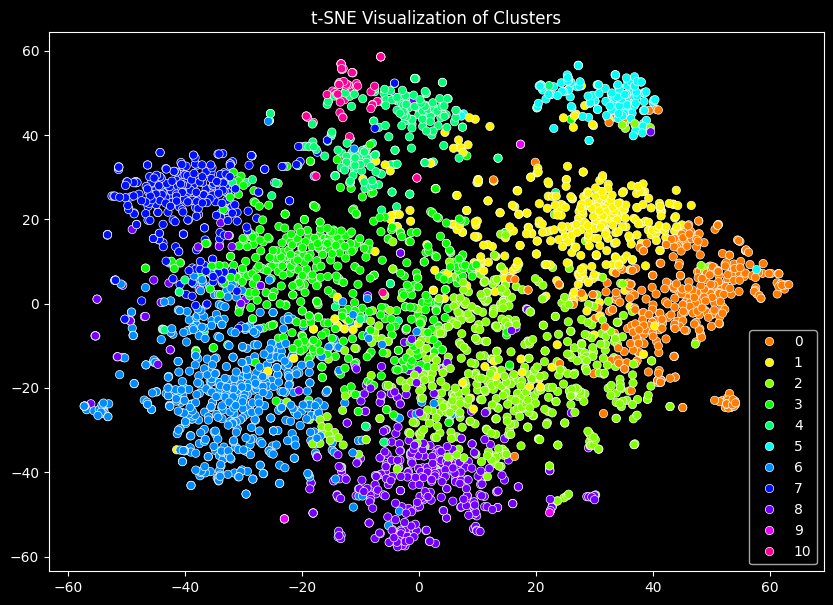

Average Jaccard Similarity: 0.57
Silhouette Score: 0.08


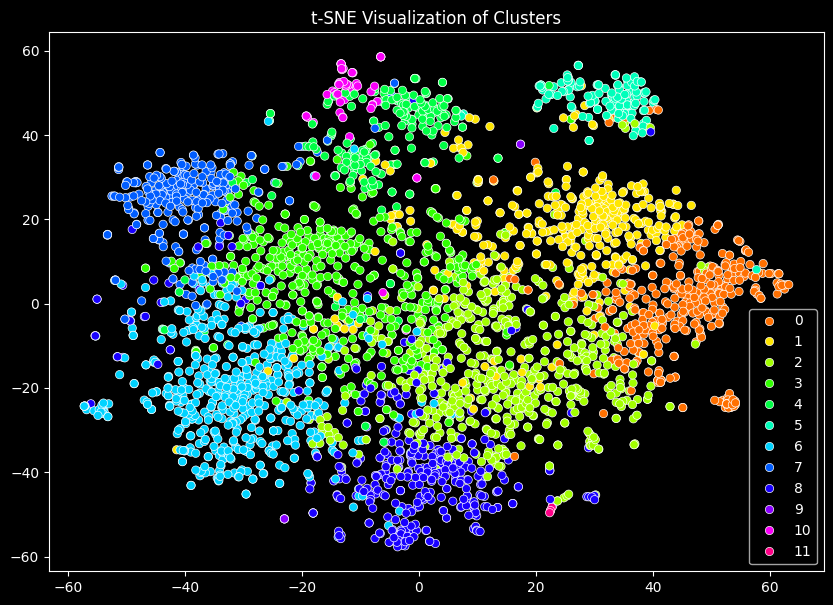

Average Jaccard Similarity: 0.56
Silhouette Score: 0.06


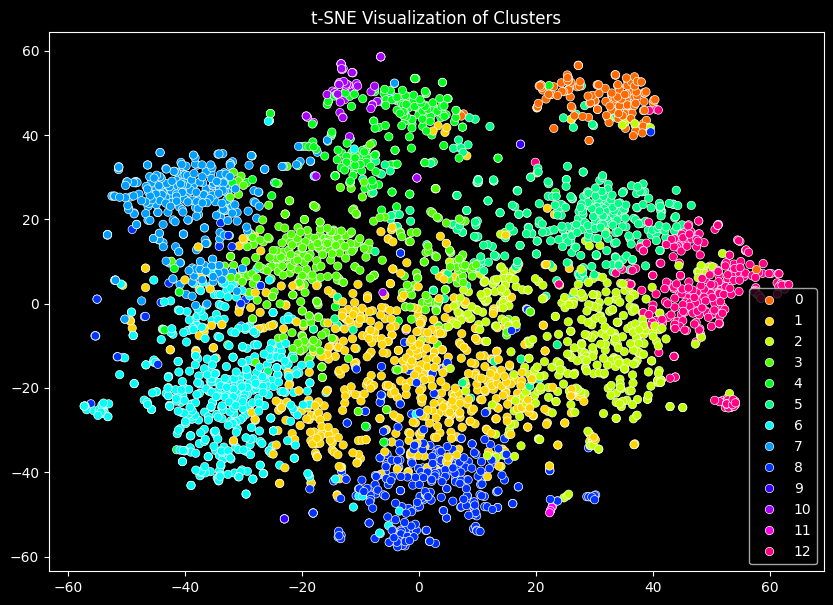

Average Jaccard Similarity: 0.55
Silhouette Score: 0.07


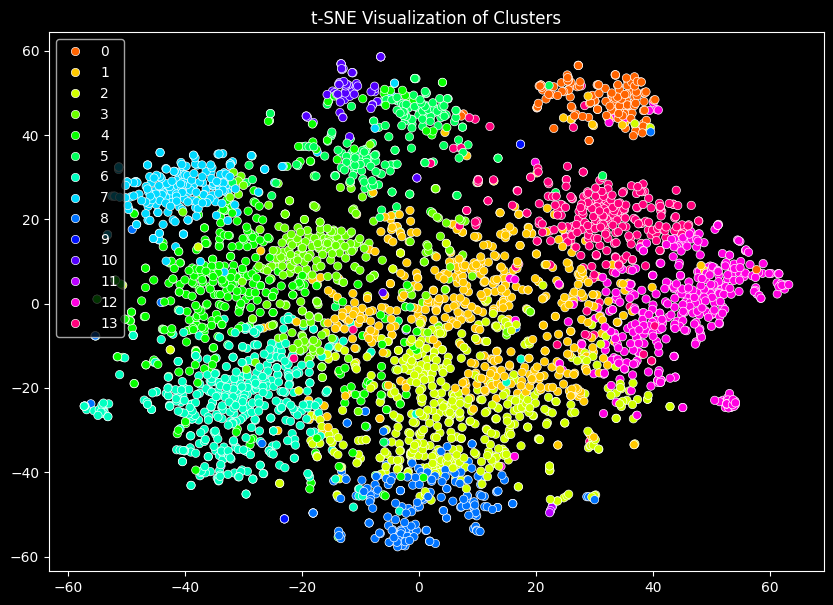

Average Jaccard Similarity: 0.59
Silhouette Score: 0.06


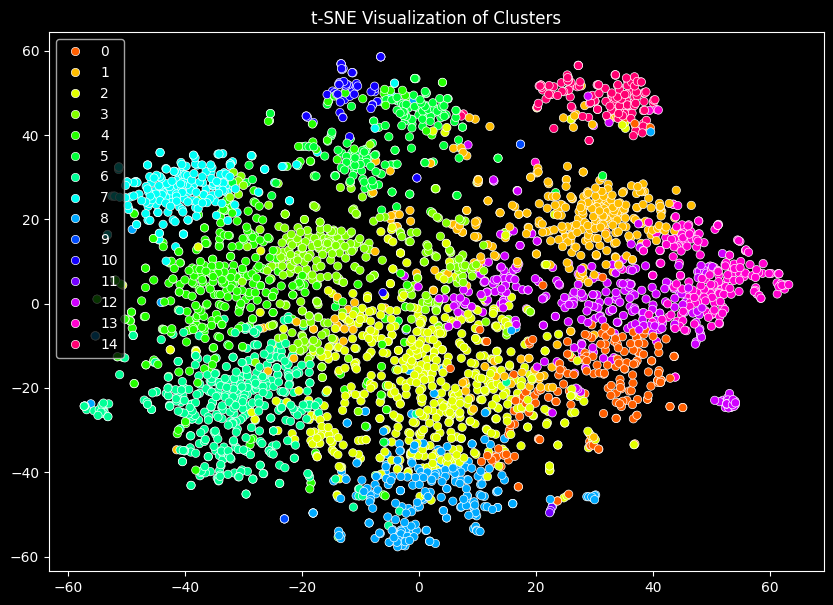

Average Jaccard Similarity: 0.56
Silhouette Score: 0.07


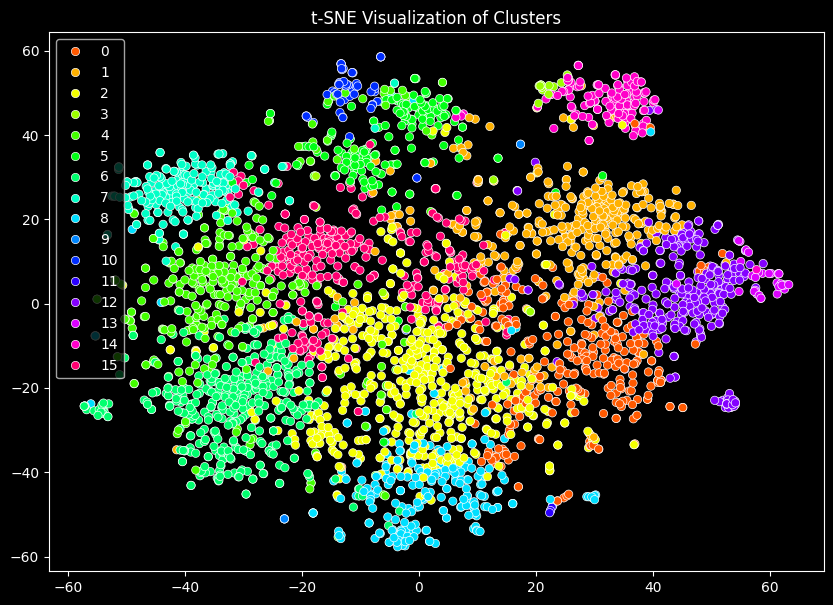

Average Jaccard Similarity: 0.53
Silhouette Score: 0.07


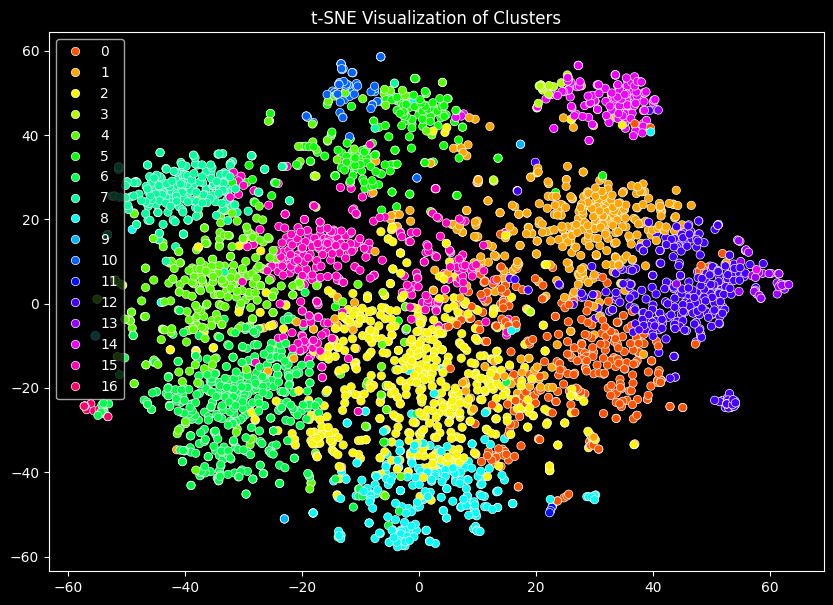

Average Jaccard Similarity: 0.51
Silhouette Score: 0.07


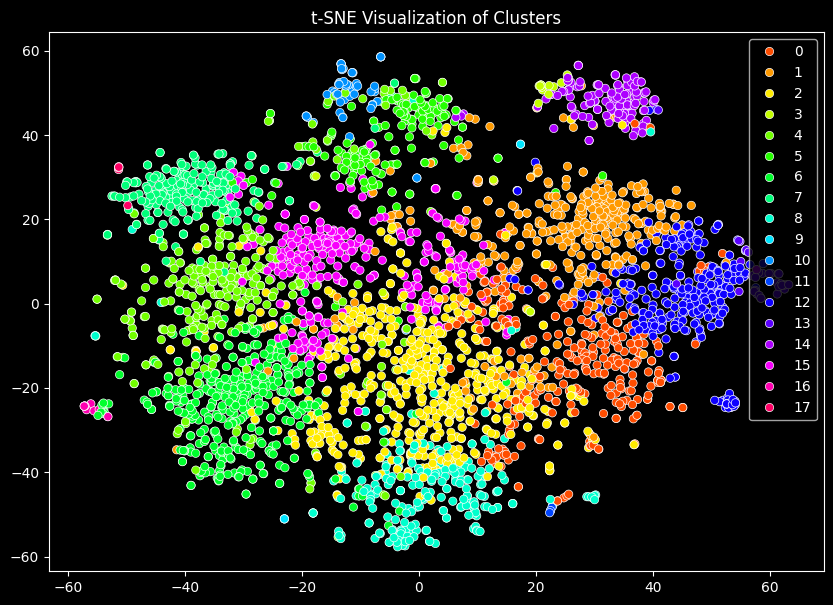

In [58]:

for n_clusters in range(5,19):

	# Perform clustering
	cluster_labels, kmeans = perform_kmeans_clustering(embeddings_df, n_clusters)


	# Compute Jaccard similarity
	jaccard = compute_jaccard_per_cluster(embeddings_df, cluster_labels, ground_truth_matrix)
	print(f"Average Jaccard Similarity: {jaccard:.2f}")

	# Compute silhouette score (optional)
	silhouette = silhouette_score(embeddings_df, cluster_labels)
	print(f"Silhouette Score: {silhouette:.2f}")

	# Visualize clusters
	visualize_clusters(embeddings_df, cluster_labels)